# Using intern to download open neuroscience data from BossDB.org

In this notebook, we'll explore using the [intern](https://github.com/jhuapl-boss/intern) library to download large-scale neuronscience image datasets from [BossDB](https://bossdb.org). 

## 1. Make sure intern is installed

In [1]:
try: 
    from intern import array
except ImportError:
    print("Intern not installed on this kernel.")

If not installed you can run ONE of the two lines below to install it with pip (uncomment the one you want), the python package manager. The following cells run a bash command that installs it to your current python library. You might have to restart the kernel after installation for intern to import correctly. You can do this by clicking "Kernel" at the top navigation bar and then clicking "Restart". You may also want to instead use a virtual environment to install intern and restart this notebook within that environment.

In [2]:
# For regular pip
# !pip install intern

# For pip3
# !pip3 install intern

## 2: Choosing a dataset

Let's choose a dataset to inspect. Visit the BossDB.org projects page (https://bossdb.org/projects) to view all of the public datasets currently hosted on BossDB. 

In this notebook, we'll explore the seminal dataset from [_"Saturated reconstruction of a volume of cortex"_](https://pubmed.ncbi.nlm.nih.gov/26232230/) (Kasthuri et al., Cell 2015) where they mapped part of the mouse cortex, available from https://bossdb.org/project/kasthuri2015.

We can use the `array()` functionality from intern to download part of the data. We will be first downloading electron microscopy image data which consists of dense arrays of integers ranging from 0 to 255. Since the EM image is grayscale we only have one channel to worry about, compared to RGB images which have three channels.

To get data, we need to provide the `array()` function an address of where the data "exists". In bossDB, we have an hierarchical organizational structure (similar to file system) where we organize datasets by "collection", "experiment", and "channel". 

Collections are the top structure containing metadata like the lab name and date of creation. Experiments are middle-level structure containing more metadata about coordinate frames (Where data exists), resolution levels, voxel size. Channels are the lowest structure and the one that actually contains volumetric data. 

The URI for a bossdb dataset therefore follows a collection -> experiment -> channel pattern. For example, the dataset we are accessing comes from the Kasthuri lab so the collection is just called `Kasthuri`. The specific dataset is called AC4 so the experiement is `AC4` and we are trying to get the EM images so the channel is `em`. 

General URI:
    
    bossdb://{Collection}/{Experiment}/{Channel}
    

For this example dataset:
    
    bossdb://Kasthuri/ac4/em

So first lets create an array object with this URI. It doesn't download any data yet, but points to where the dataset lives to easily grab "cutouts" or subsets of the data. 

In [3]:
dataset = array("bossdb://Kasthuri/ac4/em")

`array` is an indexable object where you can specify X,Y,Z ranges and download that portion of data. How do you know what ranges even exist in the data? You can check `shape` attribute for that information.

In [4]:
dataset.shape

(100, 1024, 1024)

Okay so this dataset is 100 voxels in the Z dimension, 1024 voxels in the X and Y dimensions.

You can also check the datatype of the object.

In [5]:
dataset.dtype

'uint8'

## 3: Downloading a subvolume

Because some BossDB datasets are many terabytes or even petabytes in size, it doesn't make sense to try to download the entire dataset all in one go. Instead, you'll probably find that you want to focus on small chunks of the data when running algorithms or processing locally. 

`intern` makes it easy to download data: We can just treat the dataset like a giant numpy array.

**Note that array coordinates are stored in ZYX order, as a convention.** This will make some later steps easier, but it can be a common "gotcha" for new users! The syntax is like regular indexing for numpy arrays:
    
    array[z_start: z_stop, y_start: y_stop, x_start: x_stop]

Lets download a portion of data and check out the resulting array. 

In [6]:
em_data = dataset[20:22, 256:768, 256:768]

Once the cell above has completed, we have a 2×512×512 pixel cutout: 

In [7]:
em_data.shape

(2, 512, 512)

Unlike the `dataset` variable, this cutout of data is actually downloaded and available on your computer! Lets check a small portion of the raw data. We should expect integers from 0 to 255. 

In [8]:
em_data[0][0:10, 0:10]

array([[135, 142, 142, 143, 139, 145, 150, 158, 166, 166],
       [146, 143, 141, 143, 148, 151, 164, 170, 165, 177],
       [164, 166, 163, 151, 151, 164, 171, 167, 160, 161],
       [149, 157, 158, 153, 158, 158, 157, 160, 161, 154],
       [149, 151, 151, 152, 148, 138, 143, 155, 154, 161],
       [153, 156, 160, 150, 136, 129, 131, 137, 147, 146],
       [156, 149, 150, 145, 144, 136, 138, 136, 141, 127],
       [154, 151, 157, 150, 148, 150, 148, 147, 145, 148],
       [152, 162, 166, 153, 155, 156, 153, 152, 138, 148],
       [157, 166, 166, 159, 156, 161, 154, 152, 135, 133]], dtype=uint8)

Looks good! But this isn't really that useful. To actually visualize the image, we can use pillow or matplotlib to plot it. In this example I plot it with matplotlib. The function we will use is `imshow()`. This takes in a 2D array and plots it using a colormap. We can use a "gray" colormap to get the authentic "electron microscope" feel.


Notice that the data we downloaded is a 3D array. Meaning that in order to plot a single image, we need to index the z dimension to a single slice so we are only plotting a 2D array. Think of it as getting a single cross-section of a cube and looking at that cross-section. Later on we will explore ways to visualize the data in 3D. 

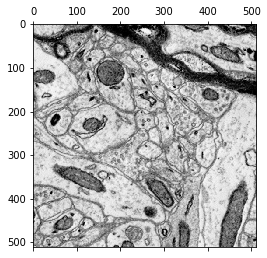

In [9]:
import matplotlib.pyplot as plt

plt.matshow(em_data[0], cmap="Greys_r")

Voila! This is actual brain tissue. You can see individual membranes, mitochondria, myelin sheath, and a bunch of other biological components in this single image. The shape of the image is 512 by 512 as seen by the axis which makes sense since our X and Y bounds were both 512. 

## 4: Coregistered channels

EM data is not the only thing in this experiment. We can also download "segmentations", or a dense labelling of all the neurons/processes in the volume. In the Kasthuri data, the neuron segmentation channel is called `neuron`. Its in the same collection and experiment as the EM channel. Typically this is what you see for a lot of the datasets, where the EM and any by-products (segmentation, annotations) exist in the same experiment. So in this case the URI for the segmentation channel would be:

    bossdb://Kasthuri/ac4/neuron
    
Note: Segmentation datatype is 64-bit integers. The reason for this is because there are so many neurons in some datasets that we need a higher bit depth to have enough integers where each neuron has its own unique ID. 

8-bit : 256 unique values  
16-bit : 65,536 unique values  
64-bit : 1.84E19 unique values  


Another Note: For plotting purposes, I would use a gradient or random color map to see all the neuron shapes clearly. Here we will use smaller color maps just for examples.

In [10]:
neuron_segmentation = array("bossdb://Kasthuri/ac4/neuron")
seg_data = neuron_segmentation[20:22, 256:768, 256:768]

Let's view the neuron segmentations

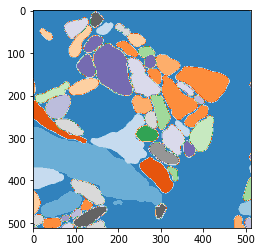

In [11]:
plt.imshow(seg_data[0], cmap="tab20c")

Looks good! Now one last thing thats super useful is to overlay both plots to get a sense of where the individual membranes are and where processes are interacting. We can do this by first plotting the EM array like before and then the seg array on top with some level of transparency.

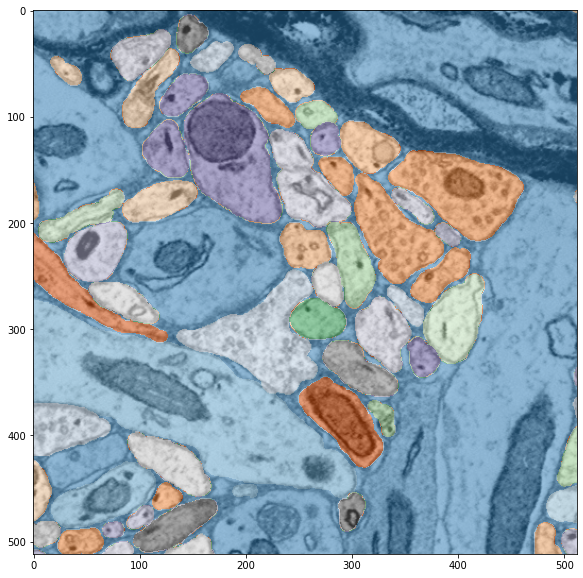

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(em_data[0], cmap="Greys_r")
ax.imshow(seg_data[0], alpha=0.5, cmap="tab20c")

As you can see above the individual neurons processes for this slices are highlighted in different colors. Now some processes can appear twice in one frame disconnecteed from each other as neurons branch out, which is why some colors show up multiple times.

For this dataset, we also have membrane and synapse channels. Let's try viewing those as well

In [13]:
mem = array("bossdb://Kasthuri/ac4/membrane")[20, 256:768, 256:768]
syn = array("bossdb://Kasthuri/ac4/synapse")[20, 256:768, 256:768]

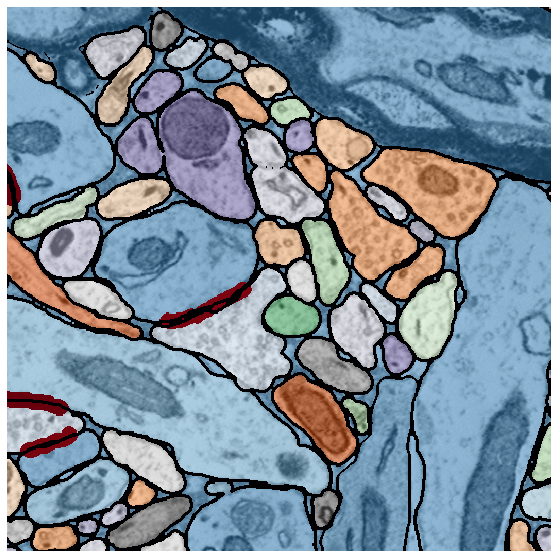

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(em_data[0], cmap="Greys_r")
ax.imshow(seg_data[0], cmap="tab20c", alpha=0.5)

ax.imshow(syn, cmap="Reds", alpha=(syn > 0).astype("uint8"))
ax.imshow(mem, cmap="magma_r", alpha=(mem > 0).astype("uint8"))
plt.axis("off")
plt.show()

## 5: Downsampled data

Sometimes we want to see a large _span_ of tissue, but we don't care about pulling it down to our local compute resources at high resolution (e.g. for visualization or gross anatomical analyses). 

BossDB and intern support this use-case by providing server-side downsampled data. Rather than downloading large volumes of data and then throwing away the high resolution information, BossDB will instead serve a lower-resolution cutout, saving you time and bandwidth. With this technique, it is possible to download and visualize full datasets without waiting for terabytes of data to download and save.

To download a downsampled cutout, we'll simply pass a `resolution` argument to the array constructor.

Resolution 0 is the highest resolution data available; resolution 1 (or "res 1") holds a downsample of every other pixel; res 2 stores every 4 pixels, and so on. As a rule of thumb, if a cube of data is 1 terabyte, then res 1 is one eighth of a terabyte (125 GB), res 2 is a little under 16 GB, and so on. (BossDB also supports anisotropic downsampling, if an imaging modality is not imaged with equal resolution. More on that later!)

To illustrate, let's download a large cutout from _"Reconstruction of motor control circuits in adult Drosophila using automated transmission electron microscopy"_ (Phelps, Hildebrand, & Graham et al., Cell 2021) (https://bossdb.org/project/phelps_hildebrand_graham2021)

In [15]:
downsampled_dataset = array("bossdb://phelps_hildebrand_graham2021/FANC/em", resolution=6)

In [16]:
downsampled_dataset.shape

(4400, 4128, 2144)

In [17]:
downsampled_cutout = downsampled_dataset[1000, :, 0:1500]

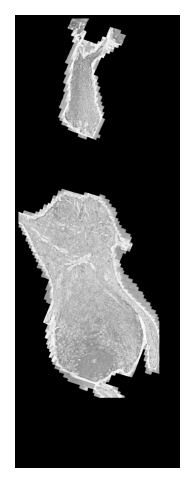

In [18]:
plt.figure(dpi=150)
plt.imshow(downsampled_cutout, cmap="Greys_r")
plt.axis("off")
plt.show()

Though this dataset spans many terabytes on disk, we are able to rapidly view gross morphology through this downsample service.